# Welcome to the Shapley Value Notebook!
In this notebook, we begin to examine Shapley Values and algorithms to approximate expected contributions for subgroup-hypothesis pairs in order to find an optimal ordering.

A few imports that will be helpful

In [81]:
import numpy as np
import pandas as pd
import copy
import sklearn as sk
import torch
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression

import model
import verifier
import cscUpdater
import updater

import importlib as imp

import itertools
import time
import dill as pickle
import seaborn as sns
import matplotlib.pyplot as plt

from hummingbird.ml import convert

import warnings
warnings.filterwarnings('ignore')

import acsDataParallel

Import data set

In [2]:
test_size = 0.2 #train-test split

acs_task = 'income' # options: employment, income, public_coverage, mobility, and travel_time.
acs_year = 2018 #must be >= 2014. Upper bound unknown.
acs_states = ['CA']
acs_horizon='1-Year' #1-Year or 5-Year
acs_survey='person' #'person' or 'household'

# for subsampling rows: can specify first and last of data to be pulled. currently pulling everything.
row_start = 0
row_end = 30000

# for subsampling columns. note: can only subsample consecutive columns with current implementation
col_start=0
col_end=-1

[train_x, train_y, test_x, test_y, demo_group_functions, demo_group_indicators, min_age, mid_age] = acsDataParallel.get_data(test_size, acs_task, acs_year, acs_states,acs_horizon=acs_horizon, acs_survey=acs_survey, row_start = row_start,row_end = row_end, col_start=col_start, col_end=col_end)

### Subgroup-Hypothesis Pairs

Define 10 subgroup-hypothesis pairs that are accepted when introduced in increasing order

In [3]:
def g1(X):
    return ((X['WKHP'] == 40))

truth_series = g1(train_x)
X_train = train_x[truth_series]
y_train = train_y[truth_series]

clf1 = sk.ensemble.RandomForestClassifier(n_estimators=100, max_depth=11,random_state=0)
clf1.fit(X_train,y_train)
clf1GPU = convert(clf1, 'pytorch')
clf1GPU.to('cuda')

def h1(x):
    return clf1GPU.predict(x)

def g2(X):
    return ((X['WKHP'] <= 20))

truth_series = g2(train_x)
X_train = train_x[truth_series]
y_train = train_y[truth_series]

clf2 = sk.ensemble.RandomForestClassifier(n_estimators=100, max_depth=11,random_state=0)
clf2.fit(X_train,y_train)
clf2GPU = convert(clf2, 'pytorch')
clf2GPU.to('cuda')
def h2(x):
    return clf2GPU.predict(x)

def g3(X):
    return ((X['RAC1P'] >= 3))

truth_series = g3(train_x)
X_train = train_x[truth_series]
y_train = train_y[truth_series]

clf3 = sk.ensemble.RandomForestClassifier(n_estimators=200, max_depth=13,random_state=0)
clf3.fit(X_train,y_train)
clf3GPU = convert(clf3, 'pytorch')
clf3GPU.to('cuda')
def h3(x):
    return clf3GPU.predict(x)

def g4(X):
    return ((X['RAC1P'] == 1))

truth_series = g4(train_x)
X_train = train_x[truth_series]
y_train = train_y[truth_series]

clf4 = sk.ensemble.RandomForestClassifier(n_estimators=200, max_depth=10,random_state=0)
clf4.fit(X_train,y_train)
clf4GPU = convert(clf4, 'pytorch')
clf4GPU.to('cuda')
def h4(x):
    return clf4GPU.predict(x)

def g5(X):
    return (X['SCHL'] <= 12)

truth_series = g5(train_x)
X_train = train_x[truth_series]
y_train = train_y[truth_series]
clf5 = sk.ensemble.RandomForestClassifier(n_estimators=100, max_depth=14,random_state=0)
clf5.fit(X_train,y_train)
clf5GPU = convert(clf5, 'pytorch')
clf5GPU.to('cuda')
def h5(x):
    return clf5GPU.predict(x)

def g6(X):
    return (X['SCHL'] >= 16)

truth_series = g6(train_x)
X_train = train_x[truth_series]
y_train = train_y[truth_series]

clf6 = sk.ensemble.GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200,max_depth = 3,random_state=0)
clf6.fit(X_train,y_train)
clf6GPU = convert(clf6, 'pytorch')
clf6GPU.to('cuda')
def h6(x):
    return clf6GPU.predict(x)

def g7(X):
    return (X['AGEP'] <=30)

truth_series = g7(train_x)
X_train = train_x[truth_series]
y_train = train_y[truth_series]
clf7 = ensemble.GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100,max_depth = 4,random_state=0)
clf7.fit(X_train,y_train)
clf7GPU = convert(clf7, 'pytorch')
clf7GPU.to('cuda')
def h7(x):
    return clf7GPU.predict(x)

def g8(X):
    return (X['COW'] == 1)

truth_series = g8(train_x)
X_train = train_x[truth_series]
y_train = train_y[truth_series]

clf8 = ensemble.GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=500,max_depth = 3,random_state=0)
clf8.fit(X_train,y_train)
clf8GPU = convert(clf8, 'pytorch')
clf8GPU.to('cuda')

def h8(x):
    return clf8GPU.predict(x)

def g9(X):
    return ((X['POBP'] <= 20) & (X['SEX'] == 2))

truth_series = g9(train_x)
X_train = train_x[truth_series]
y_train = train_y[truth_series]

clf9 = sk.ensemble.RandomForestClassifier(n_estimators=200, max_depth=15,random_state=0)
clf9.fit(X_train,y_train)
clf9GPU = convert(clf9, 'pytorch')
clf9GPU.to('cuda')
def h9(x):
    return clf9GPU.predict(x)

def g10(X):
    return ((X['OCCP'] <= 100))

truth_series = g10(train_x)
X_train = train_x[truth_series]
y_train = train_y[truth_series]

clf10 = ensemble.GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=30,max_depth = 4,random_state=0)
clf10.fit(X_train,y_train)
clf10GPU = convert(clf10, 'pytorch')
clf10GPU.to('cuda')
def h10(x):
    return clf10GPU.predict(x)

In [4]:
train_x

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
0,18.0,2.0,16.0,5.0,4110.0,34.0,17.0,15.0,1.0,9.0
1,55.0,1.0,21.0,1.0,4850.0,42.0,0.0,45.0,2.0,1.0
2,40.0,1.0,16.0,1.0,3500.0,6.0,2.0,40.0,2.0,8.0
3,54.0,1.0,18.0,5.0,5740.0,303.0,10.0,40.0,2.0,1.0
4,35.0,2.0,19.0,1.0,2040.0,416.0,1.0,4.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...
23995,23.0,1.0,16.0,5.0,4950.0,6.0,2.0,16.0,1.0,1.0
23996,22.0,1.0,21.0,5.0,5860.0,6.0,2.0,4.0,2.0,6.0
23997,35.0,1.0,22.0,1.0,1320.0,247.0,1.0,45.0,2.0,6.0
23998,41.0,1.0,20.0,1.0,410.0,6.0,2.0,50.0,2.0,1.0


In [5]:
group_list = [g1,g2,g3,g4,g5,g6,g7,g8,g9,g10]
predicate_list = [h1,h2,h3,h4,h5,h6,h7,h8,h9,h10]

In [1]:
# for group in range(1,len(group_list)+1):
#     file = open('g'+str(group)+'.pkl','wb')
#     pickle.dump(globals()['g'+str(group)],file)

# for pred in range(1,len(predicate_list)+1):
#     file = open('h'+str(pred)+'.pkl','wb')
#     pickle.dump(globals()['clf'+str(pred)+'GPU'],file)

NameError: name 'group_list' is not defined

In [391]:
# for group in range(1,11):
#     file = open('g'+str(group)+'.pkl','rb')
#     globals()['g'+str(group)] = pickle.load(file)

# for pred in range(1,11):
#     file = open('h'+str(pred)+'.pkl','rb')
#     globals()['h'+str(pred)] = pickle.load(file)

In [6]:
def verify_size(x, group):
# helper function that checks that the discovered group isn't too small to run on
    g_indices = group(x) == 1
    g_xs = x[g_indices]
    if len(g_xs) == 0:
        return False
    else:
        return True

In [7]:
initial_model = DecisionTreeClassifier(max_depth = 1, random_state=0)
initial_model.fit(train_x, train_y);

mod = model.PointerDecisionList(initial_model.predict, [])
mod.test_errors.append(cscUpdater.measure_group_errors(mod, test_x, test_y))
mod.train_errors.append(cscUpdater.measure_group_errors(mod, train_x, train_y))

In [8]:
def fractional_shapley_value(mod,permutation, group_list, predicate_list):
    
    #initialize empty array
    contribution_array = np.zeros(len(permutation))
    
    #save current PDL
    file = open('pdl.pkl','wb')
    pickle.dump(mod,file)
    
    #iterate over permuation
    for value in permutation:
        #check for improvement
        improvement_check = verifier.is_proposed_group_good_csc(mod, test_x, test_y, 
                                                                predicate_list[value],group_list[value])
        if improvement_check:
            # run the update
            cscUpdater.iterative_update(mod, predicate_list[value], group_list[value], train_x,
                                        train_y, test_x, test_y, 'g'+str(value))
            
    #compute error over test set given permuation with all players
    permutation_error = sk.metrics.zero_one_loss(test_y,np.array(mod.predict(test_x),dtype=bool))
    
    #iterate over permutation
    for value in permutation:
        #load previous PDL version
        file = open('pdl.pkl','rb')
        mod = pickle.load(file)
        
        #for each index in the permutation, compute the PDL without the group being introduced
        for sub_value in permutation[permutation.index(value)+1:]:
            #check improvement
            improvement_check = verifier.is_proposed_group_good_csc(mod, test_x, test_y, 
                                                                    predicate_list[sub_value],
                                                                    group_list[sub_value])
            if improvement_check:
            # run the update
                cscUpdater.iterative_update(mod, predicate_list[sub_value], group_list[sub_value], 
                                            train_x, train_y, test_x, test_y, 'g'+str(sub_value))
                
        #compute error over test set without player i in permutation
        error_without_group = sk.metrics.zero_one_loss(test_y,np.array(mod.predict(test_x),dtype=bool))
        
        #add player's fractional shapley contribution to array
        contribution_array[value] += (error_without_group - permutation_error)
        
        #reload PDL prior to removing player i
        file = open('pdl.pkl','rb')
        mod = pickle.load(file)
        
        #check improvement on previous PDL given player i
        improvement_check = verifier.is_proposed_group_good_csc(mod, test_x, test_y, 
                                                                predicate_list[value],group_list[value])
        if improvement_check:
            # run the update
            cscUpdater.iterative_update(mod, predicate_list[value], group_list[value], 
                                        train_x, train_y, test_x, test_y, 'g'+str(value))
        #save PDL with player i include
        file = open('pdl.pkl','wb')
        pickle.dump(mod,file)
        
    #return fractional shapley contribution over permutation for all players
    return contribution_array
        

initial_model = DecisionTreeClassifier(max_depth = 1, random_state=0)
initial_model.fit(train_x, train_y);

mod = model.PointerDecisionList(initial_model.predict, [])
mod.test_errors.append(cscUpdater.measure_group_errors(mod, test_x, test_y))
mod.train_errors.append(cscUpdater.measure_group_errors(mod, train_x, train_y))
<!-- contribution = fractional_shapley_value(mod,[1,0,2,5,4,3,6,7], group_list, predicate_list) -->

In [21]:
contribution

array([ 0.00033333,  0.00016667,  0.0005    ,  0.        , -0.00016667,
        0.00166667,  0.00066667,  0.00166667])

In [23]:
mod = model.PointerDecisionList(initial_model.predict, [])
mod.test_errors.append(cscUpdater.measure_group_errors(mod, test_x, test_y))
mod.train_errors.append(cscUpdater.measure_group_errors(mod, train_x, train_y))

for value in [1,0,2,5,4,3,6,7]:
    improvement_check = verifier.is_proposed_group_good_csc(mod, test_x, test_y, predicate_list[value],group_list[value])
    if improvement_check:
        # run the update
        cscUpdater.iterative_update(mod, predicate_list[value], group_list[value], train_x, train_y, test_x, test_y, 'g'+str(value))
print(f' Error incluiding g4: {mod.test_errors[-1][0]}')

mod = model.PointerDecisionList(initial_model.predict, [])
mod.test_errors.append(cscUpdater.measure_group_errors(mod, test_x, test_y))
mod.train_errors.append(cscUpdater.measure_group_errors(mod, train_x, train_y))

for value in [1,0,2,5,3,6,7]:
    improvement_check = verifier.is_proposed_group_good_csc(mod, test_x, test_y, predicate_list[value],group_list[value])
    if improvement_check:
        # run the update
        cscUpdater.iterative_update(mod, predicate_list[value], group_list[value], train_x, train_y, test_x, test_y, 'g'+str(value))
print(f' Error not incluiding g4: {mod.test_errors[-1][0]}')     
print('Incluiding g4 in this permutation hurts the overall accuracy!')

 Error incluiding g4: 0.15466666666666662
 Error not incluiding g4: 0.15449999999999997
Incluiding g4 in this permutation hurts the overall accuracy!


### Way to show that you can produce an ordering where each item is accepted but not optimal error

In [ ]:
permutation = [0, 1, 2, 3, 4, 6, 5, 7]
output_pdl_error(permutation)
permutation = [0, 1, 2, 3, 4, 5, 6, 7]
output_pdl_error(permutation)

Now, we define a permutation with the Shapley Values in increasing order, but we force negative values to be at the end of the permutation since we know them to hurt more than they help. We want to add those groups which may only contribute a small amount on average first so they are not forgotten in later rounds.

In [9]:
def get_shapley_ordering_iterative(contribution):
    contribution_copy = copy.deepcopy(contribution)
    lower_than_zero = []
    for index in range(len(contribution_copy)):
        if contribution_copy[index] <= 0:
            contribution_copy[index] = contribution_copy[index]*-1 + 1
    return list(np.argsort(contribution_copy, kind = 'stable'))

In [10]:
def get_shapley_ordering(contribution):
    for index in range(len(contribution)):
        if contribution[index] < 0:
            contribution[index] = 1
    return np.argsort(contribution)

In [12]:
def output_pdl_error(ordering):
    mod = model.PointerDecisionList(initial_model.predict, [])
    mod.test_errors.append(cscUpdater.measure_group_errors(mod, test_x, test_y))
    mod.train_errors.append(cscUpdater.measure_group_errors(mod, train_x, train_y))
    for value in ordering:
        improvement_check = verifier.is_proposed_group_good_csc(mod, test_x, test_y, predicate_list[value],group_list[value])
        if improvement_check:
            # run the update
            cscUpdater.iterative_update(mod, predicate_list[value], group_list[value], train_x, train_y, test_x, test_y, 'g'+str(value))
    print(f' Shapley Ordering Error: {mod.test_errors[-1][0]}')   
    return mod.test_errors[-1][0]

In [13]:
mod = model.PointerDecisionList(initial_model.predict, [])
mod.test_errors.append(cscUpdater.measure_group_errors(mod, test_x, test_y))
mod.train_errors.append(cscUpdater.measure_group_errors(mod, train_x, train_y))
fractional_shapley_value(mod,[0,1,2,3,4,5,6,7], group_list, predicate_list)

KeyboardInterrupt: 

In [107]:
get_shapley_ordering_iterative(contribution)

[0, 1, 2, 4, 5, 7, 3, 6]

In [109]:
output_pdl_error([0, 1, 2, 4, 5, 7, 3, 6])

True
True
True
True
True
True
False
False
 Shapley Ordering Error: 0.15533333333333332


In [103]:
output_pdl_error(new_permutation)

True
True
True
True
True
True
True
True
 Shapley Ordering Error: 0.15383333333333338


In [11]:
def get_shapley_ordering_iterative(contribution):
    #create copy
    contribution_working_copy = copy.deepcopy(contribution)
    
    #initialize final output array
    output_array = []
    
    #keep track of negative contributions
    less_than_zero_indices = []
    
    #keep track of positive contributions
    greater_than_zero_indices = []
    
    #iterate over contributions
    for item in range(len(contribution)):
        
        #add zero contribution indices to the start of the new permutation
        if contribution[item] == 0:
            output_array.append(item)
            
        #save positive contributions for later
        if contribution[item] > 0:
            greater_than_zero_indices.append(item)
            
        #save negative contributions for later
        if contribution[item] < 0:
            less_than_zero_indices.append(item)
    #append positive contribution indices in order
    for item in greater_than_zero_indices:
        output_array.append(item)
    
    #reorder working copy to maintain order of negative contributions
    contribution_working_copy = np.argsort(contribution_working_copy, kind='stable')
    
    #add negative contribution indices to output array
    for item in np.flip(range(len(less_than_zero_indices))):
        output_array.append(contribution_working_copy[item])
        
    #return final array
    return output_array

In [140]:
#define the initial model
initial_model = DecisionTreeClassifier(max_depth = 1, random_state=0)
initial_model.fit(train_x, train_y);
mod = model.PointerDecisionList(initial_model.predict, [])
mod.test_errors.append(cscUpdater.measure_group_errors(mod, test_x, test_y))
mod.train_errors.append(cscUpdater.measure_group_errors(mod, train_x, train_y))

#create an arbitrary permutation
old_permutation = [0, 1, 2, 4, 5, 7, 3, 6]

#compute the shapley contribution of this permutation
contribution = fractional_shapley_value(mod,old_permutation, group_list, predicate_list)

#update the permutation via our algorithm
new_permutation = get_shapley_ordering_iterative(contribution)

#compute the error on this new permutation
output_pdl_error(new_permutation)

#loop until all values are positive
while not all(i > 0 for i in contribution):
    mod = model.PointerDecisionList(initial_model.predict, [])
    mod.test_errors.append(cscUpdater.measure_group_errors(mod, test_x, test_y))
    mod.train_errors.append(cscUpdater.measure_group_errors(mod, train_x, train_y))
    
    #if you get stuck in a loop, randomly choose a new starting point
    if old_permutation == new_permutation:
        new_permutation = np.random.permutation(8).tolist()
        
    #update permutation
    old_permutation = new_permutation
    
    #recompute shapley contribution
    contribution = fractional_shapley_value(mod,old_permutation, group_list, predicate_list)
    
    #update permutation
    new_permutation = get_shapley_ordering_iterative(contribution)
    
    #print new error
    output_pdl_error(new_permutation)
   

[0.00066667 0.00033333 0.0005     0.         0.0005     0.002
 0.         0.001     ]
True
True
True
True
True
True
True
True
 Shapley Ordering Error: 0.15449999999999997
[0.0005     0.001      0.00083333 0.00016667 0.0005     0.00216667
 0.0005     0.002     ]
[3, 6, 0, 1, 2, 4, 5, 7]
[0, 1, 2, 3, 4, 5, 6, 7]
True
True
True
True
True
True
True
True
 Shapley Ordering Error: 0.15383333333333338


We now attempt to take the average Shapley Value over many permutations to see of there is correlation with this metric. Using 8 groups, we will take permutations and output the ordering 

In [20]:
groups=[0,1,2,3,4,5,6,7]

permutations_list = list(itertools.permutations(groups))

#define which permutations we will take
selection = np.random.choice(len(permutations_list), size=10000, replace=False, p=None)

In [21]:
indices_used = copy.deepcopy(selection)

In [22]:
#define groups used for permutations
groups=[0,1,2,3,4,5,6,7]

#save permutations order
permutations_index = []

#running shapley value contribution totals
shapley_array = np.zeros(len(groups))

mod = model.PointerDecisionList(initial_model.predict, [])
mod.test_errors.append(cscUpdater.measure_group_errors(mod, test_x, test_y))
mod.train_errors.append(cscUpdater.measure_group_errors(mod, train_x, train_y))

#save base PDL
file = open('basepdl.pkl','wb')
pickle.dump(mod,file)
   
#intialize df to record shapley values
shapley_df = pd.DataFrame(columns= groups)

#initialize counter
counter = 1

for index in selection:
    
    #reload base PDL  
    file = open('basepdl.pkl','rb')
    mod = pickle.load(file)
    
    #define ordering
    permutation = permutations_list[index]
    
    #get fractional contributions
    fractional_contribution = fractional_shapley_value(mod,permutation, group_list, predicate_list)

    #add fractional contribution
    shapley_array += fractional_contribution
    
    shapley_df.loc[counter] = fractional_contribution
    counter += 1
    print(counter)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

KeyboardInterrupt: 

In [27]:
shapley_df.to_csv('Shapley Dataframe Permutations.csv', index=False)

In [28]:
loaded_df = pd.read_csv('Shapley Dataframe Permutations.csv')

In [31]:
loaded_df.sum()

0    0.130000
1   -0.306667
2   -0.583833
3   -0.342333
4    1.030833
5    2.332500
6    0.475333
7    2.088167
dtype: float64

In [32]:
get_shapley_ordering(loaded_df.sum().to_list())

array([0, 6, 1, 2, 3, 4, 7, 5])

In [33]:
output_pdl_error([0,1,2,3,4,5,6,7])

True
True
True
True
True
True
True
True
 Shapley Ordering Error: 0.15383333333333338


# Graphs

In [311]:
def get_worst_shapley_ordering(contribution):
    return np.flip(np.argsort(contribution))

In [33]:
finding_worst_df = loaded_df.copy()
finding_worst_df['sum'] = finding_worst_df[['0','1','2','3','4','5','6','7']].sum(axis=1)

In [37]:
worst_perms = finding_worst_df.sort_values(by =['sum'], ascending=True).iloc[0:10]['permutation index']
best_perms = finding_worst_df.sort_values(by =['sum'], ascending=False).iloc[0:10]['permutation index']
print(worst_perms)
print(best_perms)

362    12884
527    15030
244     4442
225    15062
657    36895
165    32340
563    34980
482    24898
193    14706
138    37748
Name: permutation index, dtype: int64
4       6752
120     6720
335     5160
265     8974
556     8968
402    18843
191     1438
459    31952
91     14096
634     1079
Name: permutation index, dtype: int64


In [38]:
permutations = list(itertools.permutations([0,1,2,3,4,5,6,7]))

In [39]:
worst_errors = []
best_errors = []
for index in worst_perms:
    permutation = permutations[index]
    worst_errors.append(output_pdl_error(permutation))
for index in best_perms:
    permutation = permutations[index]
    best_errors.append(output_pdl_error(permutation))

 Shapley Ordering Error: 0.15716666666666668
 Shapley Ordering Error: 0.15716666666666668
 Shapley Ordering Error: 0.15733333333333333
 Shapley Ordering Error: 0.15700000000000003
 Shapley Ordering Error: 0.15716666666666668
 Shapley Ordering Error: 0.15700000000000003
 Shapley Ordering Error: 0.15700000000000003
 Shapley Ordering Error: 0.15700000000000003
 Shapley Ordering Error: 0.15700000000000003
 Shapley Ordering Error: 0.15700000000000003
 Shapley Ordering Error: 0.15400000000000003
 Shapley Ordering Error: 0.15383333333333338
 Shapley Ordering Error: 0.15383333333333338
 Shapley Ordering Error: 0.15416666666666667
 Shapley Ordering Error: 0.15416666666666667
 Shapley Ordering Error: 0.15449999999999997
 Shapley Ordering Error: 0.15449999999999997
 Shapley Ordering Error: 0.15416666666666667
 Shapley Ordering Error: 0.15416666666666667
 Shapley Ordering Error: 0.15449999999999997


In [41]:
optimal_error = [.15383333333333338, .15383333333333338, .15383333333333338, .15383333333333338, .15383333333333338, .15383333333333338,.15383333333333338, .15383333333333338, .15383333333333338, .15383333333333338]
worst_error = [.15733333333333333, .15733333333333333, .15733333333333333, .15733333333333333, .15733333333333333, .15733333333333333, .15733333333333333, .15733333333333333, .15733333333333333, .15733333333333333]

In [44]:
graph_df = pd.DataFrame.from_dict({'Highest Shapley Contributions':best_errors, 
                                   'Lowest Shapley Contributions':worst_errors, 
                                   'Optimal Error':optimal_error, 
                                   'Worst Error':worst_error})

In [70]:
graph_df_melted = graph_df.melt('Rank',var_name = 'Permutation Errors', value_name = 'Error')

Text(0, 0.5, 'Error')

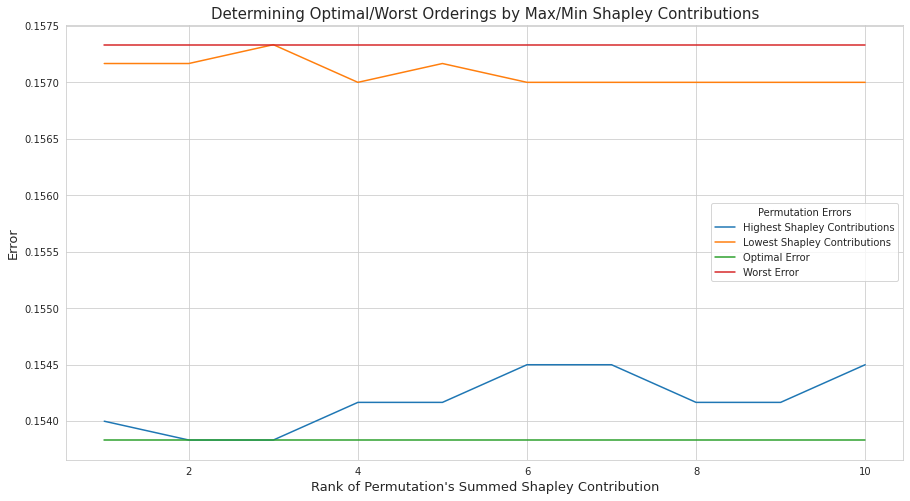

In [86]:
plt.figure(figsize = (15,8))
sns.set_style("whitegrid")
sns_plt = sns.lineplot(data=graph_df_melted, x= 'Rank', y='Error', hue='Permutation Errors' )
sns_plt.set_title('Determining Optimal/Worst Orderings by Max/Min Shapley Contributions', fontsize = 15)
sns_plt.set_xlabel('Rank of Permutation\'s Summed Shapley Contribution', fontsize = 13)
sns_plt.set_ylabel('Error', fontsize = 13)

In [87]:
all_perms_increasing = finding_worst_df.sort_values(by =['sum'], ascending=True)['permutation index']
increasing_contributions = finding_worst_df.sort_values(by =['sum'], ascending=True)['sum'] 

In [89]:
# all_errors = []
# for index in all_perms_increasing:
#     permutation = permutations[index]
#     all_errors.append(output_pdl_error(permutation))

 Shapley Ordering Error: 0.15716666666666668
 Shapley Ordering Error: 0.15716666666666668
 Shapley Ordering Error: 0.15733333333333333
 Shapley Ordering Error: 0.15700000000000003
 Shapley Ordering Error: 0.15716666666666668
 Shapley Ordering Error: 0.15700000000000003
 Shapley Ordering Error: 0.15700000000000003
 Shapley Ordering Error: 0.15700000000000003
 Shapley Ordering Error: 0.15700000000000003
 Shapley Ordering Error: 0.15700000000000003
 Shapley Ordering Error: 0.15700000000000003
 Shapley Ordering Error: 0.15700000000000003
 Shapley Ordering Error: 0.15733333333333333
 Shapley Ordering Error: 0.15733333333333333
 Shapley Ordering Error: 0.15716666666666668
 Shapley Ordering Error: 0.15700000000000003
 Shapley Ordering Error: 0.15700000000000003
 Shapley Ordering Error: 0.15700000000000003
 Shapley Ordering Error: 0.15716666666666668
 Shapley Ordering Error: 0.15716666666666668
 Shapley Ordering Error: 0.15700000000000003
 Shapley Ordering Error: 0.15700000000000003
 Shapley O

 Shapley Ordering Error: 0.15583333333333338
 Shapley Ordering Error: 0.15583333333333338
 Shapley Ordering Error: 0.15533333333333332
 Shapley Ordering Error: 0.15566666666666662
 Shapley Ordering Error: 0.15566666666666662
 Shapley Ordering Error: 0.15566666666666662
 Shapley Ordering Error: 0.15600000000000003
 Shapley Ordering Error: 0.15583333333333338
 Shapley Ordering Error: 0.15583333333333338
 Shapley Ordering Error: 0.15583333333333338
 Shapley Ordering Error: 0.15583333333333338
 Shapley Ordering Error: 0.15549999999999997
 Shapley Ordering Error: 0.15549999999999997
 Shapley Ordering Error: 0.15566666666666662
 Shapley Ordering Error: 0.15566666666666662
 Shapley Ordering Error: 0.15566666666666662
 Shapley Ordering Error: 0.15566666666666662
 Shapley Ordering Error: 0.15566666666666662
 Shapley Ordering Error: 0.15566666666666662
 Shapley Ordering Error: 0.15566666666666662
 Shapley Ordering Error: 0.15566666666666662
 Shapley Ordering Error: 0.15516666666666667
 Shapley O

 Shapley Ordering Error: 0.15483333333333338
 Shapley Ordering Error: 0.15483333333333338
 Shapley Ordering Error: 0.15500000000000003
 Shapley Ordering Error: 0.15500000000000003
 Shapley Ordering Error: 0.15516666666666667
 Shapley Ordering Error: 0.15500000000000003
 Shapley Ordering Error: 0.15516666666666667
 Shapley Ordering Error: 0.15516666666666667
 Shapley Ordering Error: 0.15549999999999997
 Shapley Ordering Error: 0.15549999999999997
 Shapley Ordering Error: 0.15549999999999997
 Shapley Ordering Error: 0.15549999999999997
 Shapley Ordering Error: 0.15549999999999997
 Shapley Ordering Error: 0.15549999999999997
 Shapley Ordering Error: 0.15549999999999997
 Shapley Ordering Error: 0.15549999999999997
 Shapley Ordering Error: 0.15549999999999997
 Shapley Ordering Error: 0.15549999999999997
 Shapley Ordering Error: 0.15533333333333332
 Shapley Ordering Error: 0.15466666666666662
 Shapley Ordering Error: 0.15516666666666667
 Shapley Ordering Error: 0.15549999999999997
 Shapley O

 Shapley Ordering Error: 0.15500000000000003
 Shapley Ordering Error: 0.15500000000000003
 Shapley Ordering Error: 0.15500000000000003
 Shapley Ordering Error: 0.15533333333333332
 Shapley Ordering Error: 0.15533333333333332
 Shapley Ordering Error: 0.15533333333333332
 Shapley Ordering Error: 0.15533333333333332
 Shapley Ordering Error: 0.15433333333333332
 Shapley Ordering Error: 0.15533333333333332
 Shapley Ordering Error: 0.15533333333333332
 Shapley Ordering Error: 0.15466666666666662
 Shapley Ordering Error: 0.15483333333333338
 Shapley Ordering Error: 0.15483333333333338
 Shapley Ordering Error: 0.15483333333333338
 Shapley Ordering Error: 0.15416666666666667
 Shapley Ordering Error: 0.15416666666666667
 Shapley Ordering Error: 0.15500000000000003
 Shapley Ordering Error: 0.15416666666666667
 Shapley Ordering Error: 0.15416666666666667
 Shapley Ordering Error: 0.15500000000000003
 Shapley Ordering Error: 0.15500000000000003
 Shapley Ordering Error: 0.15483333333333338
 Shapley O

In [92]:
graph_all_df = pd.DataFrame.from_dict({'Error':all_errors, 'Summed Shapley Contribution':increasing_contributions})

Text(0, 0.5, 'Error')

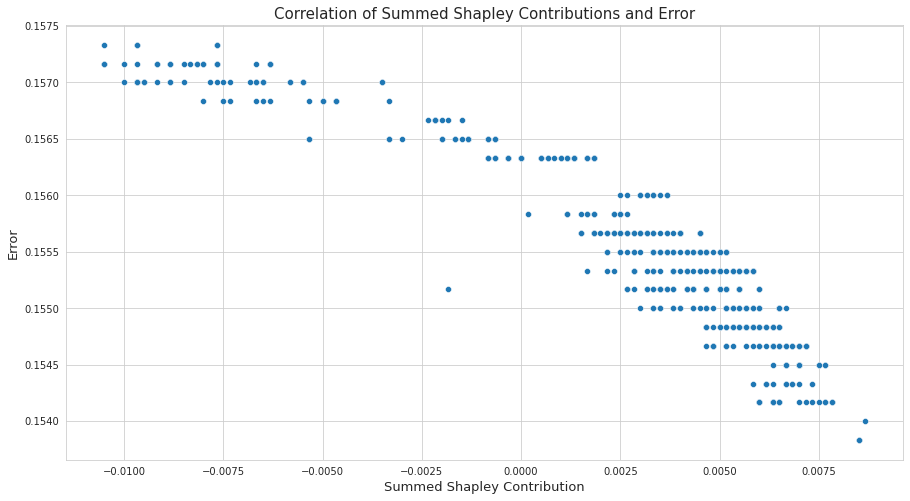

In [94]:
plt.figure(figsize = (15,8))
sns.set_style("whitegrid")
sns_plt = sns.scatterplot(data=graph_all_df, x= 'Summed Shapley Contribution', y='Error')
sns_plt.set_title('Correlation of Summed Shapley Contributions and Error', fontsize = 15)
sns_plt.set_xlabel('Summed Shapley Contribution', fontsize = 13)
sns_plt.set_ylabel('Error', fontsize = 13)

In [200]:
fractional_shapley_value(mod,[0, 1, 2, 4, 7, 3, 5, 6], group_list, predicate_list)

array([-0.00216667, -0.00266667, -0.002     , -0.00166667,  0.0005    ,
        0.        ,  0.        , -0.00166667])

In [350]:
fractional_shapley_value(mod,[0, 1, 2, 3, 4, 5, 6, 7], group_list, predicate_list)

array([0.00016667, 0.0015    , 0.0005    , 0.00083333, 0.0005    ,
       0.0025    , 0.00066667, 0.00183333])

In [351]:
best = [0.00016667, 0.0015    , 0.0005    , 0.00083333, 0.0005    ,0.0025    , 0.00066667, 0.00183333]

In [352]:
worst = [-0.00216667, -0.00266667, -0.002     , -0.00166667,  0.0005    , 0.        ,  0.        , -0.00166667]

In [358]:
latex_df = pd.DataFrame.from_dict({'Best permutation': best, 'Worst permutation': worst})

In [363]:
print(latex_df.style.to_latex())

\begin{tabular}{lrr}
 & Best permutation & Worst permutation \\
1 & 0.000167 & -0.002167 \\
2 & 0.001500 & -0.002667 \\
3 & 0.000500 & -0.002000 \\
4 & 0.000833 & -0.001667 \\
5 & 0.000500 & 0.000500 \\
6 & 0.002500 & 0.000000 \\
7 & 0.000667 & 0.000000 \\
8 & 0.001833 & -0.001667 \\
\end{tabular}



In [381]:
print(fractional_shapley_value(mod,permutations[1621], group_list, predicate_list))
output_pdl_error(permutations[1621])

[ 0.          0.          0.         -0.00066667  0.0005      0.001
  0.0005      0.0015    ]
 Shapley Ordering Error: 0.15533333333333332


0.15533333333333332

In [380]:
mod = model.PointerDecisionList(initial_model.predict, [])
mod.test_errors.append(cscUpdater.measure_group_errors(mod, test_x, test_y))
mod.train_errors.append(cscUpdater.measure_group_errors(mod, train_x, train_y))

In [382]:
permutations[1621]

(0, 3, 2, 5, 6, 1, 7, 4)

In [391]:
selection = np.random.choice(len(permutations_list), size=10000, replace=False, p=None, random_state = 0)

TypeError: choice() got an unexpected keyword argument 'random_state'